---

# **Insult Commentry Classification**
## **Machine Learning Individual Project**
---

## **1. Import Libraries & Dependencies**

In [1]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
from sklearn import metrics
from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer

## **2. Load Dataset & Preprocessing**

Load the training and testing dataset from google drive.

In [2]:
drive.mount('/content/drive/', force_remount=True)
sys_path = '/content/drive/My Drive/Colab Notebooks/ML Project/'
sys.path.append(sys_path)
fn_train = os.path.join(sys_path, 'train.csv')
fn_test = os.path.join(sys_path, 'test_with_solutions.csv')

print('Path to training data: {}'.format(fn_train))
print('Path to testing data: {}'.format(fn_test))

Mounted at /content/drive/
Path to training data: /content/drive/My Drive/Colab Notebooks/ML Project/train.csv
Path to testing data: /content/drive/My Drive/Colab Notebooks/ML Project/test_with_solutions.csv


Store the data in numpy arrays.

The load_data function extract labels and the corresponding comments from training and testing dataset which are being used for future preprocessing.  

In [3]:
def load_data(filename):
  with open(filename) as f:
    header = f.readline()
    labels = []
    sentences = []
    for line in f.readlines():
      data = line.split(',') # split the dataset to Insult(label), Date, Comment
      labels.append(int(data[0]))
      sentences.append(data[2])
      # discard the date information
    comment = sentences
    label = labels
    return label, comment

def load_more_data(filename, datas, labels):
  with open(filename) as f:
    header = f.readline()
    for line in f.readlines():
      data = line.split(',') # split the dataset to Insult(label), Date, Comment
      labels.append(int(data[0]))
      datas.append(data[2])
    comment = np.array(datas)
    label = np.array(labels)
    return label, comment

In [4]:
label_set, data_set = load_data(fn_train)
label_set, data_set = load_more_data(fn_test, data_set, label_set)
label_set = np.array(label_set)
data_set = np.array(data_set)

Visualize the labels and sentences we have for now.

In [5]:
print(label_set)

[1 0 0 ... 0 1 0]


In [6]:
print(data_set)

['"""You fuck your dad."""\n'
 '"""i really don\'t understand your point.\\xa0 It seems that you are mixing apples and oranges."""\n'
 '"""A\\\\xc2\\\\xa0majority of Canadians can and has been wrong before now and will be again.\\\\n\\\\nUnless you\'re supportive of the idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them\'s the breaks and we can always regard you as collateral damage like in wartime - and sorry'
 ... '"""Question: Are you a boy or a girl?"""'
 '"""Leave your email or phone number and maybe you 2 twits can meet up and beat each other up.\\xa0 tough guy talk online is cheap. go ahead and man up midnight train and do the real thing. dont be an internet pussy! fight him in a ring. dont talk shit DO IT!"""'
 '"""From the scenarios you present']


Remove non-essential elements in the sentence, e.g punctuations, numbers, stop words.

The sentence_washer() function takes a string and an array that shows the specific element that we want to elinminate and replace all those by a single space.

In [7]:
def sentence_washer(sentence, list):
  for element in list:
    sentence = sentence.replace(element, ' ')
  return sentence

### Preprocess the training dataset

In [8]:
## Convert labels [0, 1] to [-1, 1]
label_set = 2 * label_set - 1

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [sentence_washer(x, digits) for x in data_set]

## Remove punctuation
punc_less = [sentence_washer(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

## Define stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
stop_cleaned = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]
print(stop_cleaned)

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) # modify max_features to improve behavior
data_features = vectorizer.fit_transform(stop_cleaned)
data_clean = data_features.toarray()

['you fuck your dad', 'really don t understand your point xa seems that you are mixing apples and oranges', 'xc xa majority canadians can and has been wrong before now and will be again n nunless you re supportive idea that nothing is full proof or perfect so you take your chances and if we should inadvertently kill your son or daughter then them s breaks and we can always regard you as collateral damage like in wartime and sorry', 'listen if you dont wanna get married man or women dont do what would bother you if gay people got married stay in your lane do you let them do them and your god is so nice but quick judg if your not like him', 'c xe c b u ea n xu u ed ng u u b u eddng bi u ec u t xecnh c xf xf n ho xe kh xf ng nc xe c ng u b d xe n ng u ed cu xed u u ea u chi u ee nh u ee c c xf xf n ho xe kh xf ng nc xe c n xf ng d xe n gi u eef u u ea t u edf v u n giang', 'sdl ok', 'yeah and where are you now', 'shut fuck up you and rest your faggot friends should be burned at stake', 'e

### The shape of dataset

In [9]:
print(label_set)

[ 1 -1 -1 ... -1  1 -1]


In [10]:
print(data_clean.shape)

(6594, 5000)


In [11]:
def count_labels(set):
  a = 0
  b = 0
  for lab in set:
    if (lab == 1):
      a += 1
    elif lab == -1:
      b += 1
  print("We have ", a, " True labels and ", b," False labels.")
  return a, b

In [12]:
a, b = count_labels(label_set)
print(b/(a+b))

We have  1742  True labels and  4852  False labels.
0.7358204428268122


### Split train and test dataset

Since we have a big gap between the number of true labels and false labels, only a small part of the dataset will be used. To get full advantage of the dataset, we choose to use every True labels.

In [13]:
label_for_train = []
data_for_train = []
label_for_test = []
data_for_test = []
label_for_validation = []
data_for_validation = []
finished = False
usedT = 0
usedF = 0
index = 0
while not finished:
  l = label_set[index]
  d = data_clean[index]
  if l == 1:
    if usedT < 1350:
      label_for_train.append(l)
      data_for_train.append(d)
    elif usedT < 1500:
      label_for_validation.append(l)
      data_for_validation.append(d)
    else:
      label_for_test.append(l)
      data_for_test.append(d)
    usedT += 1
  elif l == -1:
    if usedF < 1350:
      label_for_train.append(l)
      data_for_train.append(d)
      usedF += 1
    elif usedF < 1500:
      label_for_validation.append(l)
      data_for_validation.append(d)
      usedF += 1
    elif usedF < 1758:
      label_for_test.append(l)
      data_for_test.append(d)
      usedF += 1
  index += 1
  finished = len(data_for_train) == 2700 and len(data_for_validation) == 300 and len(data_for_test) == 500    

count_labels(label_for_train)
count_labels(label_for_test)
count_labels(label_for_validation)
data_for_train = np.array(data_for_train)
label_for_train = np.array(label_for_train)
data_for_test = np.array(data_for_test)
label_for_test = np.array(label_for_test)
label_for_validation = np.array(label_for_validation)
data_for_validation = np.array(data_for_validation)

We have  1350  True labels and  1350  False labels.
We have  242  True labels and  258  False labels.
We have  150  True labels and  150  False labels.


## **3. SVM model**

###  Implement the hinge loss function and the smooth hinge loss function

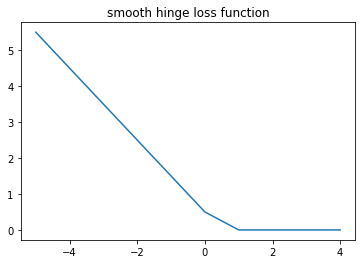

In [14]:
def hinge_loss_smooth(t):
  if t <= 0:
    return 0.5-t
  elif 0 < t < 1:
    return 0.5*np.square(1-t)
  elif 1 <= t:
    return 0

# Plot the figure

plot_x = np.arange(-5, 5, 1)
loss_smooth = np.vectorize(lambda g: hinge_loss_smooth(g))

plt.plot( plot_x, loss_smooth(plot_x))
plt.title('smooth hinge loss function')
plt.show()

### Impement 

Obtain the partial derivatives from $\frac{1}{2} \lVert W \rVert ^{2} + C\sum_{i=1}^{n} \ell(X_{i}^{T} + W)$

In [15]:
def weight_derivative(theta, theta0, C,feature_matrix, labels):

    grad_theta = 2 * theta
    grad_theta0 = 0
    for i in range(feature_matrix.shape[0]):
      t = np.dot(np.dot(feature_matrix[i],theta) + theta0,labels[i])
      if t <= 0:
        grad_theta -= np.dot(labels[i], feature_matrix[i])
        grad_theta0 -= -C*labels[i]
      elif 0 < t < 1:
        grad_theta -= np.dot((1 - np.dot(np.dot(feature_matrix[i],theta + theta0),labels[i])), np.dot(labels[i], feature_matrix[i]))
        grad_theta0 -= C*np.dot((1 - np.dot(np.dot(feature_matrix[i],theta + theta0),labels[i])), labels[i])
      elif 1 <= t:
        continue
    return grad_theta, grad_theta0

theta = np.ones(data_for_train.shape[1])
theta0 = np.ones(1)
C = 1
grad_theta, grad_theta0 = weight_derivative(theta, theta0, C, data_for_train, label_for_train)

print (grad_theta[:10])
print (grad_theta0)

[ 3.  3.  2.  4.  5.  2.  2.  4.  3. 80.]
-1350


In [16]:
def objective(feature_matrix, labels, theta,theta0, C):
    score = (feature_matrix.dot(theta)+theta0)*labels
    return np.sum(0.5 * theta**2)+C*np.sum([hinge_loss_smooth(t) for t in score])

In [17]:
def adam_optimizer(feature_matrix, labels, initial_theta,initial_theta0, C, step_size=0.01, tolerence=0.01, b1=0.9, b2=0.999, eps=10**-8, max_iteration=1000):

    converged = False 
    m = np.zeros(len(initial_theta))
    v = np.zeros(len(initial_theta))
    m0 = np.zeros(1)
    v0 = np.zeros(1)
    theta = np.array(initial_theta)
    theta0 = np.array(initial_theta0) 
    i = 0
    iters = []
    errs = []
    gradients = []
    while not converged and i < max_iteration:
        i += 1
        grad_theta, grad_theta0  = weight_derivative(theta, theta0, C,feature_matrix, labels)
        
        m = (1 - b1) * grad_theta      + b1 * m 
        v = (1 - b2) * (grad_theta**2) + b2 * v 
        mhat = m / (1 - b1**(i + 1))   
        vhat = v / (1 - b2**(i + 1))
        theta = theta - step_size*mhat/(np.sqrt(vhat) + eps)
        
        m0 = (1 - b1) * grad_theta0      + b1 * m0 
        v0 = (1 - b2) * (grad_theta0**2) + b2 * v0  
        mhat0 = m0 / (1 - b1**(i + 1))  
        vhat0 = v0 / (1 - b2**(i + 1))
        theta0 = theta0 - step_size*mhat0/(np.sqrt(vhat0) + eps)
        
        
        gradient_magnitude = np.sqrt(np.sum(grad_theta**2))
        
        
        if gradient_magnitude < tolerance:
            converged = True
        
        preds_train = model_predict(data_for_train,theta,theta0)

        errs_train = np.sum((preds_train > 0.0) != (label_for_train > 0.0))

        print ("Iteration: ",i,"objective: ",objective(feature_matrix, labels, theta,theta0, C),"tr err: ",float(errs_train)/len(label_for_train),"gradient_magnitude: ", gradient_magnitude) # for us to check about convergence
        iters.append(1)
        errs.append(float(errs_train)/len(label_for_train))
        gradients.append(gradient_magnitude)
    plt.plot(errs)
    plt.title('training error')
    plt.show()
    plt.plot(gradients)
    plt.title('gradient magnitude')
    plt.show()
    plt.plot(gradients[50:])
    plt.title('gradient magnitude 50-')
    plt.show()
    return(theta, theta0)

## **4. Training and Evaluation**


In [18]:
def model_predict(feature_matrix,theta,theta0):
    h =  feature_matrix.dot(theta)+theta0
    y_h = (h >= 0)*2-1
    
    return y_h 

Iteration:  1 objective:  23885.055938002977 tr err:  0.5 gradient_magnitude:  1244.4902570932406
Iteration:  2 objective:  23222.35963516335 tr err:  0.5 gradient_magnitude:  1243.5094183747044
Iteration:  3 objective:  22527.65425412304 tr err:  0.5 gradient_magnitude:  1242.3871447504614
Iteration:  4 objective:  21819.08529843751 tr err:  0.5 gradient_magnitude:  1241.208936726878
Iteration:  5 objective:  21105.327893147256 tr err:  0.5 gradient_magnitude:  1240.0053563725023
Iteration:  6 objective:  20391.242841571446 tr err:  0.5 gradient_magnitude:  1238.791021554326
Iteration:  7 objective:  19679.84518869157 tr err:  0.5 gradient_magnitude:  1237.5741346480831
Iteration:  8 objective:  18973.141074474206 tr err:  0.5 gradient_magnitude:  1236.3597966120742
Iteration:  9 objective:  18272.533943216997 tr err:  0.5 gradient_magnitude:  1235.1514148730453
Iteration:  10 objective:  17579.041471635144 tr err:  0.5 gradient_magnitude:  1233.9513862418253
Iteration:  11 objective:

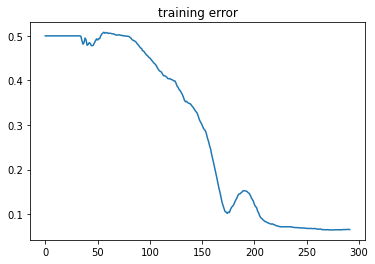

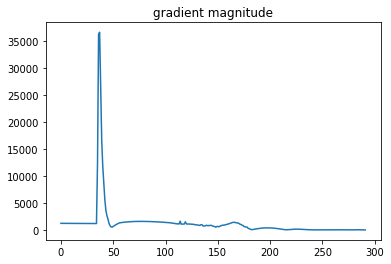

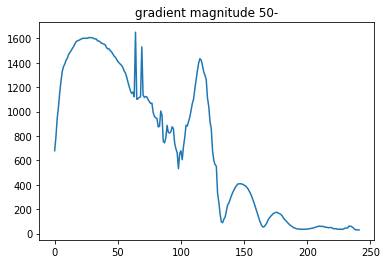

[-1.74130646e-01  1.40480163e-01  1.11142555e-01 ...  2.11467446e-01
  3.05223812e-07  3.05223812e-07]
[-0.01545461]


In [19]:
initial_theta = np.ones(data_for_train.shape[1])
initial_theta0 = np.ones(1)
C = 1
step_size = 0.03
max_iter = 10000000
tolerance = 30

theta, theta0 = adam_optimizer(data_for_train ,label_for_train, initial_theta, initial_theta0,C, step_size, tolerance, max_iteration=max_iter)
print(theta)
print(theta0)

In [21]:
## Get predictions on training and test data
preds_train = model_predict(data_for_train,theta,theta0)
preds_test = model_predict(data_for_test,theta,theta0)

## Compute errors
errs_train = np.sum((preds_train > 0.0) != (label_for_train > 0.0))
errs_test = np.sum((preds_test > 0.0) != (label_for_test > 0.0))

print ("Training error: ", float(errs_train)/len(label_for_train))
print ("Test error: ", float(errs_test)/len(label_for_test))

Training error:  0.06555555555555556
Test error:  0.292
